## Data Downloading and Unzipping

In [1]:
!pip install gdown

In [2]:
!gdown http://drive.google.com/uc?id=1ZEyNMEO43u3qhJAwJeBZxFBEYc_pVYZQ
!unzip -q dataset.zip

Downloading...
From (original): http://drive.google.com/uc?id=1ZEyNMEO43u3qhJAwJeBZxFBEYc_pVYZQ
From (redirected): https://drive.google.com/uc?id=1ZEyNMEO43u3qhJAwJeBZxFBEYc_pVYZQ&confirm=t&uuid=4cff60d4-b8d8-4001-808e-646a22fbd340
To: /kaggle/working/dataset.zip
100%|███████████████████████████████████████| 1.13G/1.13G [00:08<00:00, 125MB/s]


# Import the essential Libraries

In [3]:
import os  # Operating system interaction
import numpy as np  # Numerical computations
from tqdm import tqdm
import matplotlib.pyplot as plt  # Plotting
import torch  # Deep learning framework
import torchvision  # Computer vision utilities
import torch.nn as nn  # Neural network building blocks
import torch.optim as optim  # Optimization algorithms
from torch.autograd import Variable  # Automatic differentiation
from torchvision import datasets, transforms, models  # Pre-trained models
from tqdm.notebook import tqdm  # Progress bars
from sklearn.metrics import roc_auc_score, roc_curve, auc  # ROC curve metrics
from sklearn.preprocessing import label_binarize  # Label binarization

# Set matplotlib backend for inline plotting
%matplotlib inline

# Plotting Images from different classes

Class : no substructure 


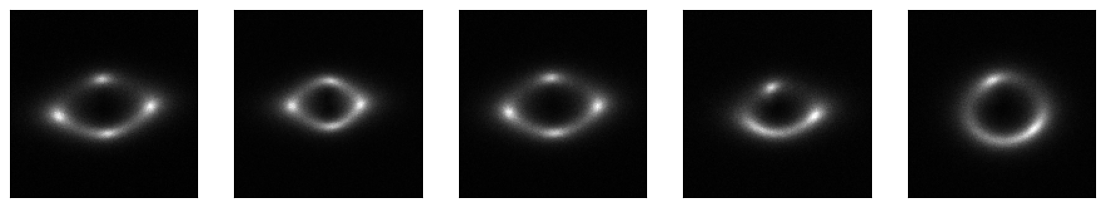

Class : Spherical substructure 


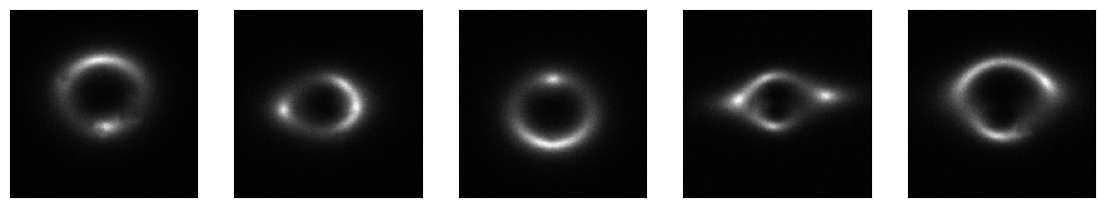

Class : Vortex substructure 


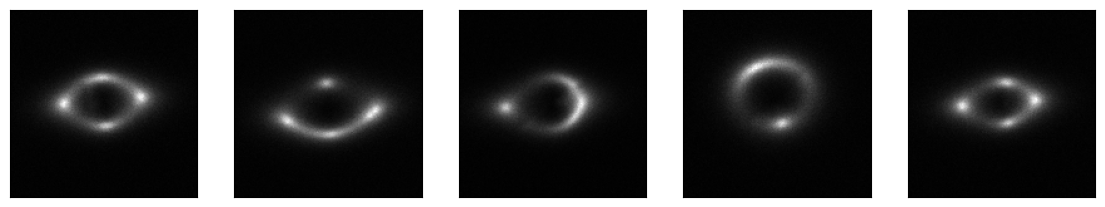

In [ ]:
# Defining the input paths for different classes
train_path1 = './dataset/train/no'  # Path for samples with no substructure
train_files1 = [os.path.join(train_path1, f) for f in os.listdir(train_path1) if f.endswith(".npy")]

train_path2 = './dataset/train/sphere'  # Path for samples with spherical substructure
train_files2 = [os.path.join(train_path2, f) for f in os.listdir(train_path2) if f.endswith(".npy")]

train_path3 = './dataset/train/vort'  # Path for samples with vortex substructure
train_files3 = [os.path.join(train_path3, f) for f in os.listdir(train_path3) if f.endswith(".npy")]

# Number of samples to display per class
n = 5

# Plotting the samples with no substructure
print('Class : no substructure ')
plt.rcParams['figure.figsize'] = [14, 14]  # Set the size of the plot
for i, image in enumerate(train_files1[:n], 1):
    ax = plt.subplot(1, n, i)  # Creating subplot
    plt.imshow(np.load(image).reshape(150, 150), cmap='gray')  # Loading and displaying the image
    ax.get_xaxis().set_visible(False)  # Hide x-axis
    ax.get_yaxis().set_visible(False)  # Hide y-axis
plt.show()

# Plotting the samples with spherical substructure
print("Class : Spherical substructure ")
plt.rcParams['figure.figsize'] = [14, 14]
for i, image in enumerate(train_files2[:n], 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(np.load(image).reshape(150, 150), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Plotting the samples with vortex substructure
print("Class : Vortex substructure ")
plt.rcParams['figure.figsize'] = [14, 14]
for i, image in enumerate(train_files3[:n], 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(np.load(image).reshape(150, 150), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Creating Pytorch format Dataset and Dataloder

In [ ]:
batch_size = 32  # Batch size for training

def load_img(path):

    tensor = torch.from_numpy(np.load(path))
    tensor = tensor.type('torch.FloatTensor')
    return tensor

def transform_img(img):
      transformer = transforms.Compose([
          transforms.Resize((150, 150)),
          transforms.RandomHorizontalFlip(),
          transforms.RandomVerticalFlip(),
          transforms.RandomRotation(20),
          transforms.Normalize(mean=[0.5], std=[0.5])
      ])
      img = transformer(img)
      return img

# creating training dataset in pytorch format
train_path = "./dataset/train"
train_data = torchvision.datasets.DatasetFolder(root=train_path, loader=load_img,transform= transform_img, extensions="npy")
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

# creating validation dataset in pytorch format
val_path = "./dataset/val"
val_data = torchvision.datasets.DatasetFolder(root=val_path, loader=load_img,transform=transform_img, extensions="npy")
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)

print("Training Classes: " + str(train_data.class_to_idx))  # Display classes and their indices
print("Validation Classes: " + str(val_data.class_to_idx))

Training Classes: {'no': 0, 'sphere': 1, 'vort': 2}
Validation Classes: {'no': 0, 'sphere': 1, 'vort': 2}


In [ ]:
def positionmat(shape):
    midx = midy =  shape/2
    mat = torch.zeros((shape,shape))

    for x in range(shape):
        for y in range(shape):
            dis = ((midx-x)**2 + (midy - y)**2)**0.5
            mat[x][y] = dis
    return mat

# for 150*150 shape image 
mat = positionmat(150)
print(mat)

tensor([[106.0660, 105.3613, 104.6614,  ..., 103.9663, 104.6614, 105.3613],
        [105.3613, 104.6518, 103.9471,  ..., 103.2473, 103.9471, 104.6518],
        [104.6614, 103.9471, 103.2376,  ..., 102.5329, 103.2376, 103.9471],
        ...,
        [103.9663, 103.2473, 102.5329,  ..., 101.8234, 102.5329, 103.2473],
        [104.6614, 103.9471, 103.2376,  ..., 102.5329, 103.2376, 103.9471],
        [105.3613, 104.6518, 103.9471,  ..., 103.2473, 103.9471, 104.6518]])


In [ ]:
import torch
import torch.nn.functional as F

class Converter():
    def __init__(self, mag=1, min_angle=-2.8, max_angle=4.232):
        self.source_mag = mag
        self.min_angle = min_angle
        self.max_angle = max_angle

    def image_to_source(self, image, centre=None, E_r=None, deflection=None, gradient=None):
        device = image.device
        # print(image.shape)
        B, _,length, width = image.shape  # Ensure batch dimension

        pixel_width = (self.max_angle - self.min_angle) / length
        if centre is None:
            centre = (length // 2, width // 2)

        centre_x = torch.tensor(centre[0], device=device)
        centre_y = torch.tensor(centre[1], device=device)

        range_x = torch.arange(-(centre_x - 1), length - (centre_x - 1), device=device)
        range_y = torch.arange(-(centre_y - 1), width - (centre_y - 1), device=device)

        x, y = torch.meshgrid(range_x, range_y, indexing='ij')
        x, y = x * pixel_width, y * pixel_width

        r = torch.sqrt(x**2 + y**2)
        r[r == 0] = 1  # Avoid division by zero

        if deflection is not None:
            if deflection.shape != (B, 2, length, width):
                raise ValueError(f"Deflection should be (B, 2, {length}, {width}), got {deflection.shape}")
            xdef = (deflection[:, 0, :, :] * x) / r
            ydef = (deflection[:, 1, :, :] * y) / r
        elif gradient is not None:
            if gradient.shape != image.shape:
                raise ValueError("Gradient and image must be the same shape")
            xdef = torch.gradient(gradient, dim=1)[0]
            ydef = torch.gradient(gradient, dim=2)[0]
        elif E_r is not None:
            k = torch.full((B, length, width), E_r, device=device)
            xdef = (k * x) / r
            ydef = (k * y) / r
        else:
            raise ValueError("Both deflection and gradient cannot be None")

        bx = (x - xdef) / pixel_width
        by = (y - ydef) / pixel_width

        bx = torch.clip(bx + centre_x * self.source_mag, 0, length * self.source_mag - 1).long()
        by = torch.clip(by + centre_y * self.source_mag, 0, width * self.source_mag - 1).long()

        # Create empty source image and counts tensor
        sourceimage = torch.zeros((B, length * self.source_mag, width * self.source_mag), dtype=image.dtype, device=device)
        counts = torch.zeros_like(sourceimage, dtype=torch.int)

        # Flatten indices
        bx = bx.view(B, -1)
        by = by.view(B, -1)
        image_flat = image.view(B, -1)

        # Flatten output shape
        flat_indices = bx * (width * self.source_mag) + by  # Convert 2D indices to 1D indices
        sourceimage.view(B, -1).scatter_add_(1, flat_indices, image_flat)
        counts.view(B, -1).scatter_add_(1, flat_indices, torch.ones_like(image_flat, dtype=torch.int, device=device))

        # Normalize source image where counts > 0
        mask = counts > 0
        sourceimage[mask] /= counts[mask]

        return sourceimage.unsqueeze(1)


torch.Size([1, 1, 150, 150])


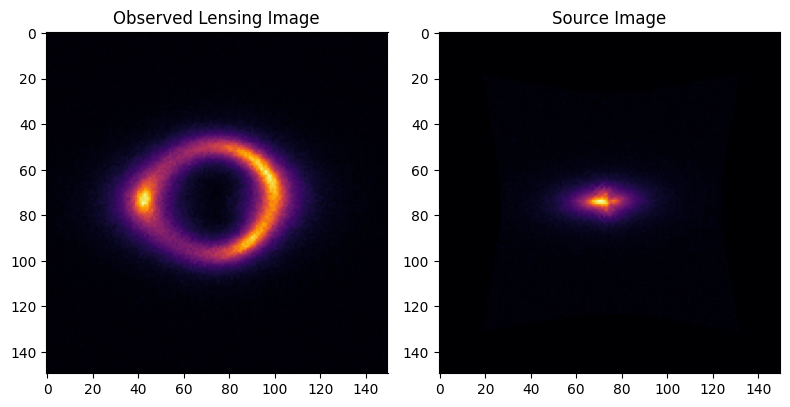

In [8]:
# Load image as a PyTorch tensor
image = np.load("./dataset/train/no/10.npy", allow_pickle=True)[0]
image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # Add batch dim
image = image.unsqueeze(0)
print(image.shape)
# Initialize Converter class
phy = Converter()

# Perform lensing transformation
source = phy.image_to_source(image, E_r=1.25)
source = source.squeeze(0,1)  # Remove batch dim for plotting


# Plot results
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(image.squeeze(0,1).numpy(), cmap="inferno")
axs[0].set_title("Observed Lensing Image")
axs[1].imshow(source.numpy(), cmap="inferno")
axs[1].set_title("Source Image")
plt.tight_layout()
plt.show()

# EfficientNetB0 Model

In [9]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, out_dim=150 * 150 * 2):
        super(ResNet, self).__init__()
        self.in_channels = 8
        self.conv1 = nn.Conv2d(1, 8, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(8)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layer(block, 8, layers[0])
        self.layer2 = self.make_layer(block, 16, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 120, layers[2], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(120, out_dim)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class PINN(nn.Module):
    def __init__(self, positionvector=None, batch=32, img_shape=150):
        super(PINN, self).__init__()
        self.positionvector = torch.tensor(positionvector, dtype=torch.float32) if positionvector is not None else None
        self.batch = batch
        self.shape = img_shape
        self.converter = Converter()

        self.encoder = ResNet(ResidualBlock, [2, 2, 2])

        self.classifier = models.efficientnet_b0(weights="DEFAULT")
        self.classifier.features[0] = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.classifier.classifier[1] = nn.Linear(in_features=1280, out_features=3, bias=True)

    def relu(self, x):
        return torch.relu(x)

    def preprocess(self, image):
        image = torch.nan_to_num(image, nan=1e-6)  
        imax = torch.max(image)
        log = torch.square(torch.sin(image / imax))
        log = torch.nan_to_num(log, nan=0.0)

        gradient_x = torch.gradient(log, dim=2)[0]
        gradient_y = torch.gradient(log, dim=3)[0]

        gradient_x = torch.nan_to_num(gradient_x, nan=0.0)
        gradient_y = torch.nan_to_num(gradient_y, nan=0.0)

        gradient = torch.gradient(gradient_x, dim=2)[0] + torch.gradient(gradient_y, dim=3)[0]
        gradient = torch.nan_to_num(gradient, nan=0.0)

        tan = torch.tanh(gradient)
        absolute = torch.abs(tan)
        return absolute

    def forward(self, img):
        batch_size = img.shape[0]  

        lens_img = img
        preprocess_img = self.preprocess(img)
        potential = self.encoder(img)
        potential = potential.view(batch_size, 2, self.shape, self.shape)  

        if self.positionvector is not None:
            self.positionvector = self.positionvector.to(img.device)
            deflection = potential * self.positionvector
        else:
            deflection = img  

        source_img = self.converter.image_to_source(img,deflection = deflection)
        threechannel_img = torch.cat((lens_img, source_img,preprocess_img), dim=1)  


        prediction = self.classifier(threechannel_img)

        return prediction

model = PINN(positionvector = mat)

/tmp/ipykernel_34/2454132340.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.positionvector = torch.tensor(positionvector, dtype=torch.float32) if positionvector is not None else None
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 119MB/s] 


# Number of trainable Parameters

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print the number of parameters in your CustomDenseNet model
num_params = count_parameters(model)
print(f"Total Trainable Parameters: {num_params}")


Total Trainable Parameters: 9876655


# Connecting Model with GPU

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Training the Model

Epoch 1/50
Train Loss: 1.1091, Train Acc: 0.3381
ROC AUC Score: 0.5057


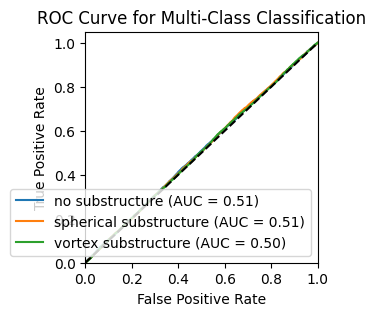

Epoch 2/50
Train Loss: 1.1038, Train Acc: 0.3362
ROC AUC Score: 0.5012


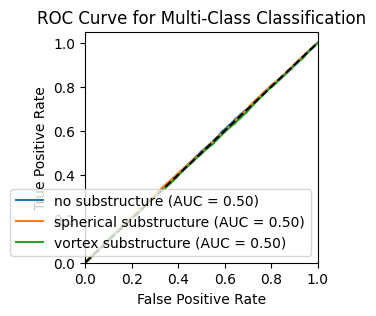

Epoch 3/50
Train Loss: 1.1019, Train Acc: 0.3339
ROC AUC Score: 0.5002


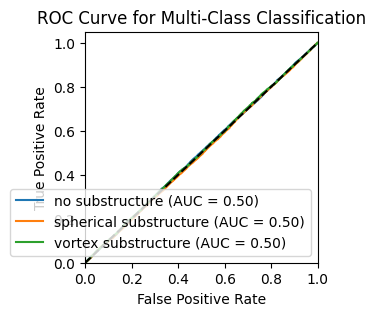

Epoch 4/50
Train Loss: 1.1010, Train Acc: 0.3344
ROC AUC Score: 0.5012


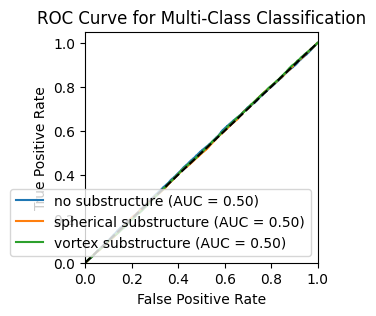

Epoch 5/50
Train Loss: 1.1005, Train Acc: 0.3341
ROC AUC Score: 0.5019


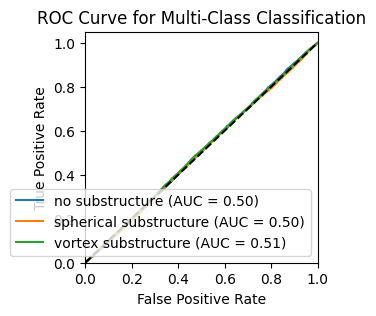

Epoch 6/50
Train Loss: 1.0992, Train Acc: 0.3452
ROC AUC Score: 0.5140


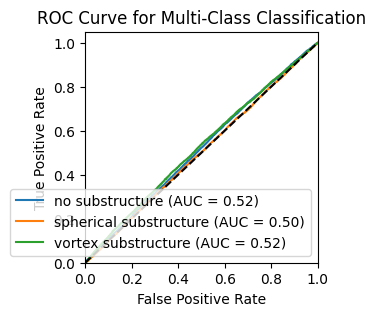

Epoch 7/50
Train Loss: 1.0970, Train Acc: 0.3542
ROC AUC Score: 0.5256


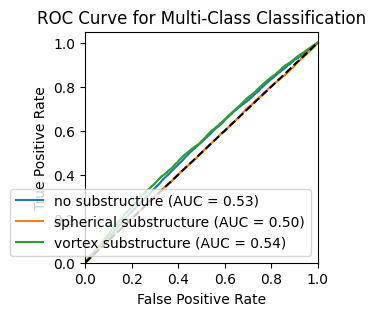

Epoch 8/50
Train Loss: 1.0981, Train Acc: 0.3461
ROC AUC Score: 0.5161


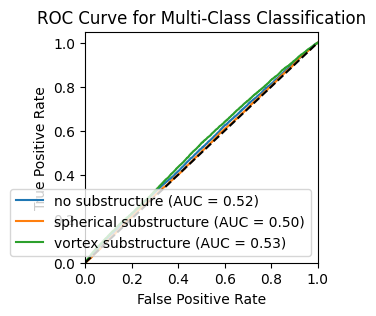

Epoch 9/50
Train Loss: 1.0972, Train Acc: 0.3503
ROC AUC Score: 0.5235


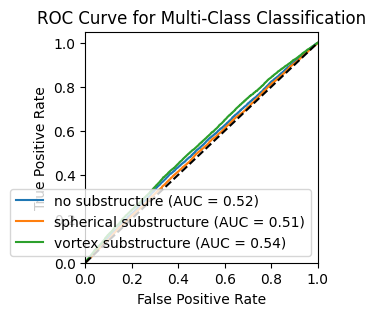

Epoch 10/50
Train Loss: 1.0853, Train Acc: 0.3799
ROC AUC Score: 0.5591


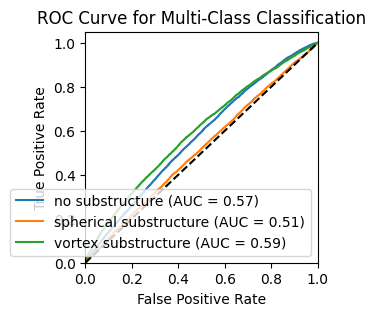

Epoch 11/50
Train Loss: 1.0259, Train Acc: 0.4484
ROC AUC Score: 0.6293


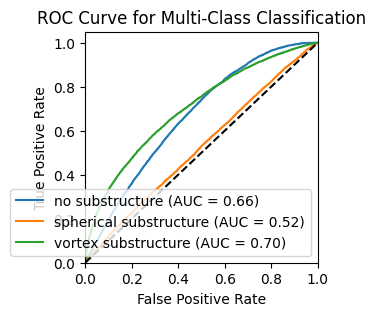

Epoch 12/50
Train Loss: 0.8538, Train Acc: 0.5889
ROC AUC Score: 0.7558


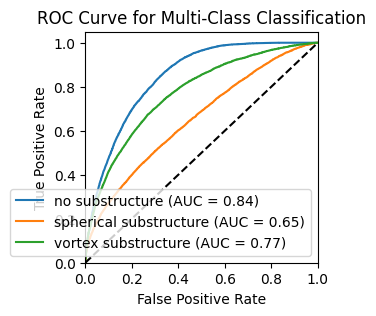

Epoch 13/50
Train Loss: 0.6556, Train Acc: 0.7109
ROC AUC Score: 0.8507


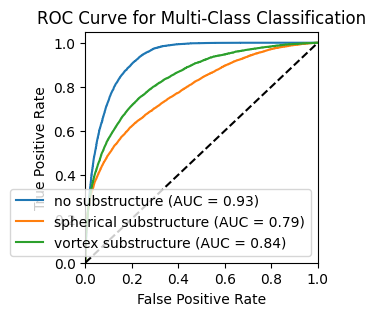

Epoch 14/50
Train Loss: 0.5384, Train Acc: 0.7745
ROC AUC Score: 0.8944


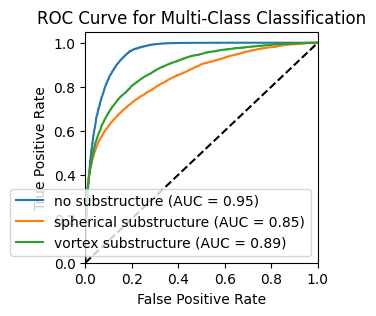

Epoch 15/50
Train Loss: 0.4589, Train Acc: 0.8108
ROC AUC Score: 0.9222


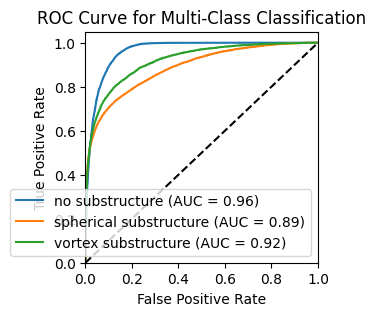

Epoch 16/50
Train Loss: 0.4058, Train Acc: 0.8368
ROC AUC Score: 0.9386


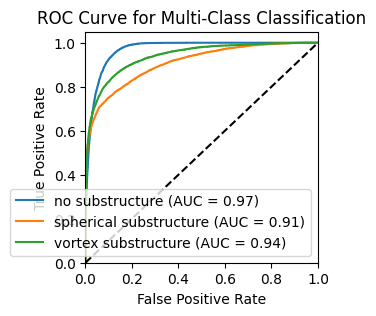

Epoch 17/50
Train Loss: 0.3670, Train Acc: 0.8541
ROC AUC Score: 0.9495


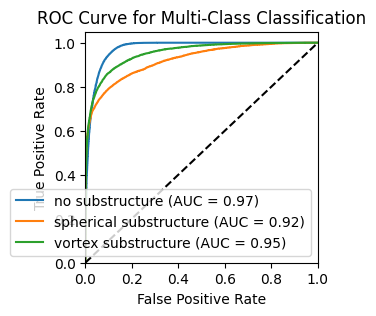

Epoch 18/50
Train Loss: 0.3429, Train Acc: 0.8638
ROC AUC Score: 0.9553


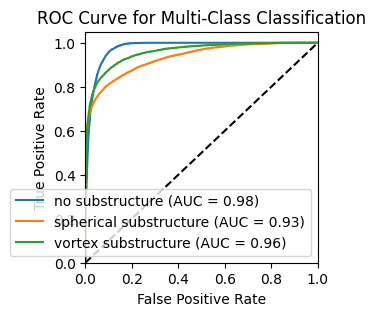

Epoch 19/50
Train Loss: 0.3259, Train Acc: 0.8709
ROC AUC Score: 0.9593


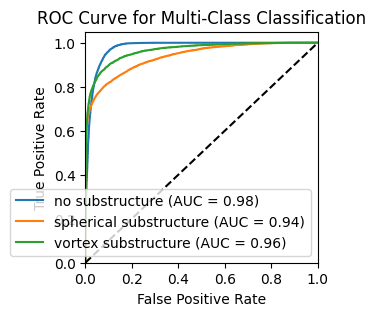

Epoch 20/50
Train Loss: 0.3062, Train Acc: 0.8812
ROC AUC Score: 0.9647


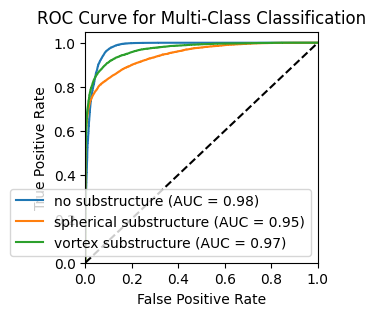

Epoch 21/50
Train Loss: 0.2920, Train Acc: 0.8867
ROC AUC Score: 0.9669


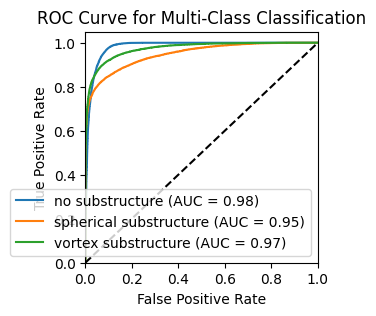

Epoch 22/50
Train Loss: 0.2794, Train Acc: 0.8918
ROC AUC Score: 0.9686


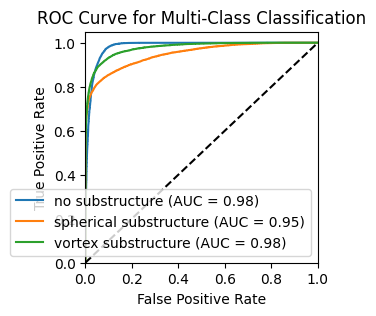

Epoch 23/50
Train Loss: 0.2658, Train Acc: 0.8987
ROC AUC Score: 0.9710


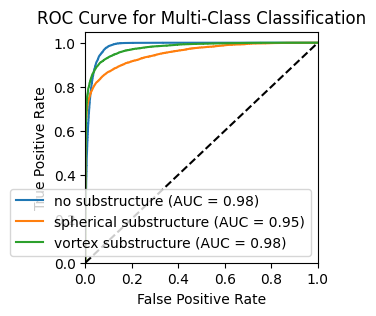

Epoch 24/50
Train Loss: 0.2569, Train Acc: 0.9031
ROC AUC Score: 0.9736


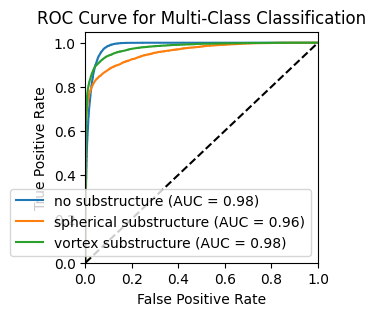

Epoch 25/50
Train Loss: 0.2509, Train Acc: 0.9055
ROC AUC Score: 0.9745


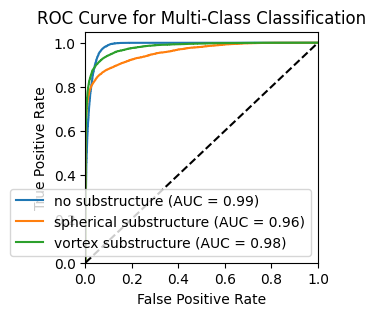

Epoch 26/50
Train Loss: 0.2403, Train Acc: 0.9099
ROC AUC Score: 0.9764


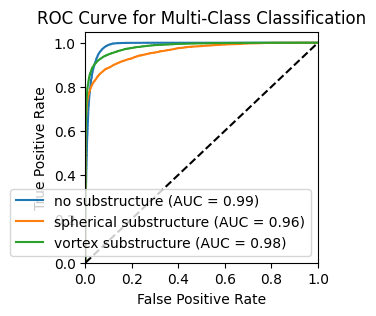

Epoch 27/50
Train Loss: 0.2377, Train Acc: 0.9102
ROC AUC Score: 0.9766


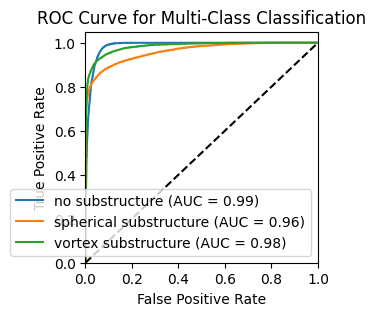

Epoch 28/50
Train Loss: 0.2290, Train Acc: 0.9148
ROC AUC Score: 0.9777


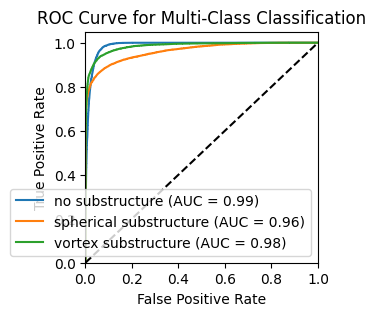

Epoch 29/50
Train Loss: 0.2227, Train Acc: 0.9181
ROC AUC Score: 0.9791


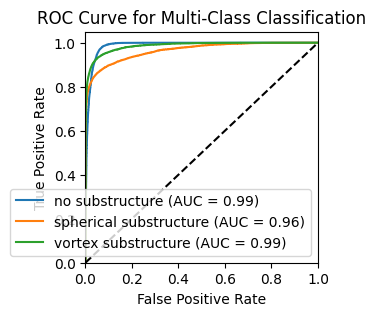

Epoch 30/50
Train Loss: 0.2174, Train Acc: 0.9184
ROC AUC Score: 0.9794


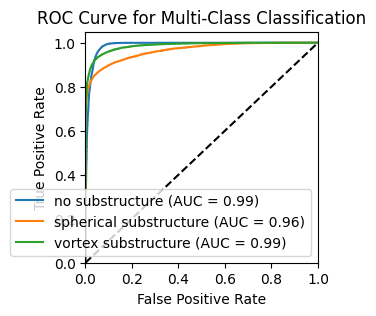

Epoch 31/50
Train Loss: 0.2133, Train Acc: 0.9218
ROC AUC Score: 0.9806


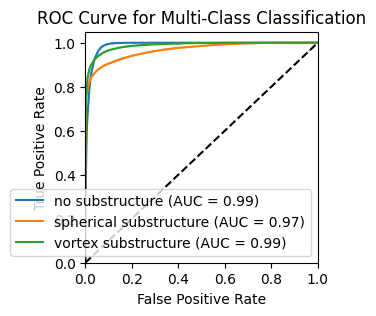

Epoch 32/50
Train Loss: 0.2094, Train Acc: 0.9212
ROC AUC Score: 0.9811


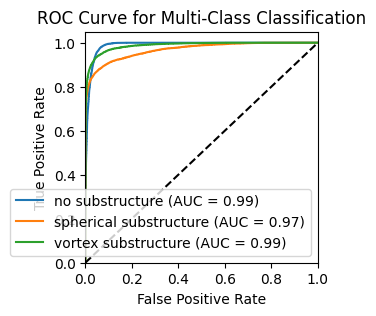

Epoch 33/50
Train Loss: 0.2052, Train Acc: 0.9221
ROC AUC Score: 0.9820


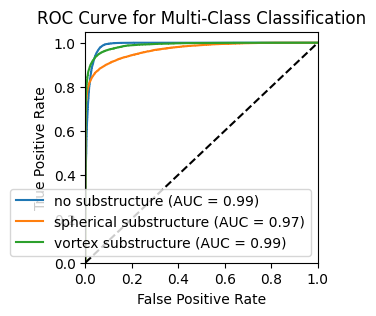

Epoch 34/50
Train Loss: 0.2028, Train Acc: 0.9234
ROC AUC Score: 0.9824


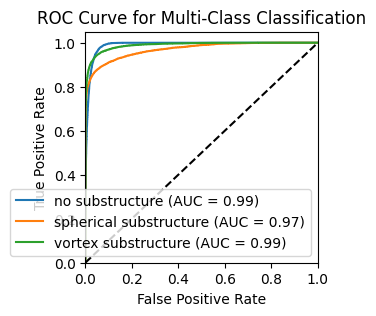

Epoch 35/50
Train Loss: 0.2006, Train Acc: 0.9266
ROC AUC Score: 0.9818


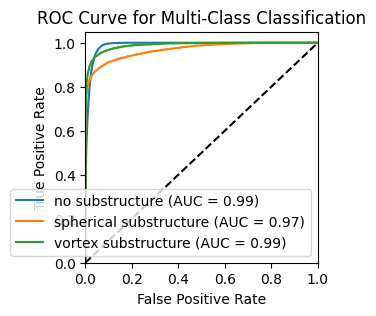

Epoch 36/50
Train Loss: 0.1936, Train Acc: 0.9275
ROC AUC Score: 0.9825


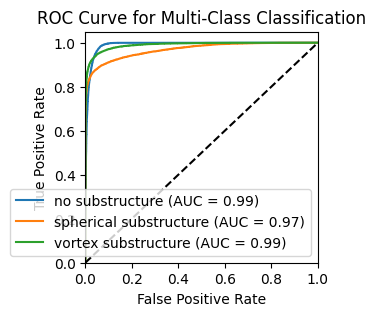

Epoch 37/50
Train Loss: 0.1910, Train Acc: 0.9300
ROC AUC Score: 0.9831


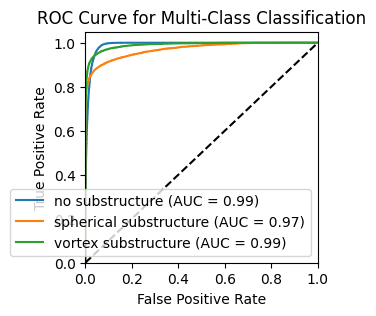

Epoch 38/50
Train Loss: 0.1890, Train Acc: 0.9285
ROC AUC Score: 0.9838


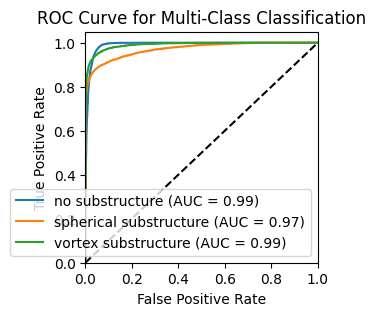

Epoch 39/50
Train Loss: 0.1872, Train Acc: 0.9320
ROC AUC Score: 0.9840


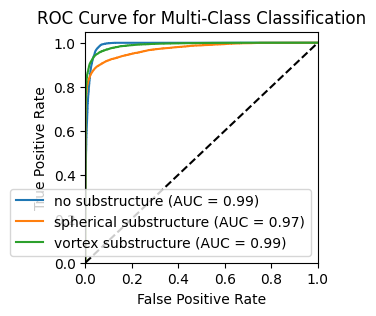

Epoch 40/50
Train Loss: 0.1846, Train Acc: 0.9316
ROC AUC Score: 0.9849


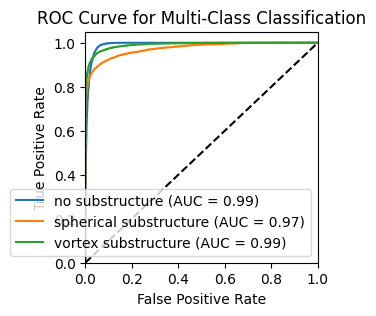

Epoch 41/50
Train Loss: 0.1790, Train Acc: 0.9338
ROC AUC Score: 0.9850


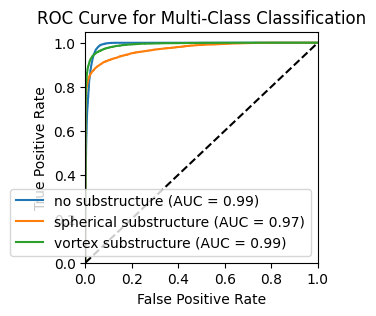

Epoch 42/50
Train Loss: 0.1809, Train Acc: 0.9336
ROC AUC Score: 0.9848


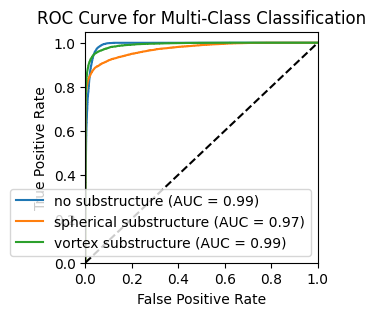

Epoch 43/50
Train Loss: 0.1757, Train Acc: 0.9355
ROC AUC Score: 0.9849


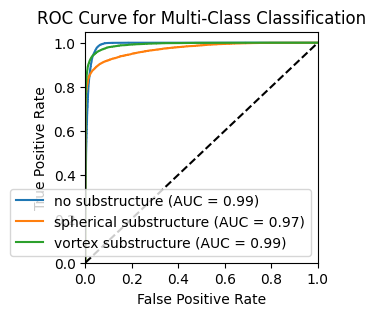

Epoch 44/50
Train Loss: 0.1770, Train Acc: 0.9356
ROC AUC Score: 0.9855


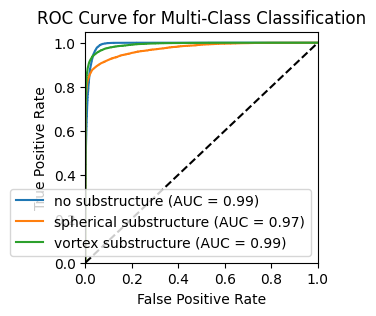

Epoch 45/50
Train Loss: 0.1685, Train Acc: 0.9394
ROC AUC Score: 0.9862


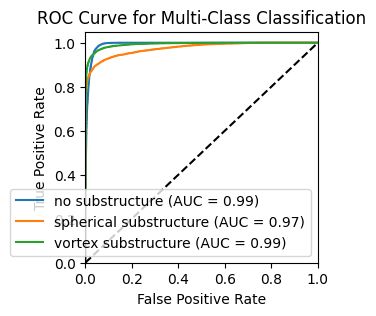

Epoch 46/50
Train Loss: 0.1641, Train Acc: 0.9390
ROC AUC Score: 0.9872


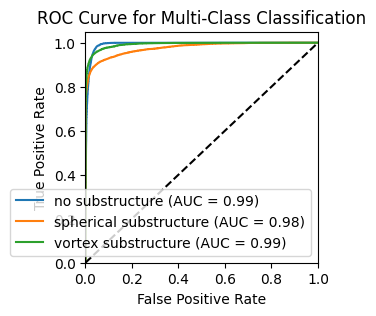

Epoch 47/50
Train Loss: 0.1655, Train Acc: 0.9398
ROC AUC Score: 0.9867


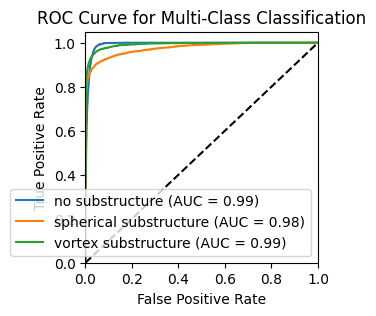

Epoch 48/50
Train Loss: 0.1613, Train Acc: 0.9406
ROC AUC Score: 0.9875


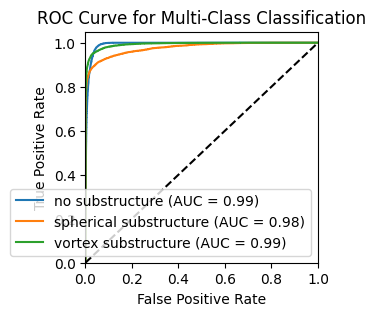

Epoch 49/50
Train Loss: 0.1629, Train Acc: 0.9406
ROC AUC Score: 0.9870


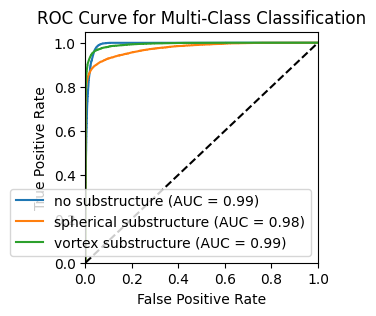

Epoch 50/50
Train Loss: 0.1546, Train Acc: 0.9447
ROC AUC Score: 0.9883


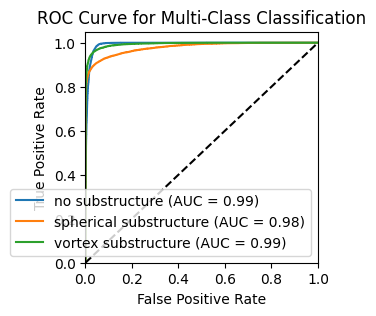

In [12]:

# Training parameters
num_epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.RAdam(model.parameters(), lr=0.0005)

# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    model.train()  # Set model to training mode

    train_loss = 0.0
    correct_predictions = 0
    total_samples = 0  # Keep track of total samples

    y_true = []
    y_scores = []
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        correct_predictions += (preds == labels).sum()
        total_samples += labels.size(0)  # Accumulate total number of samples

        loss = criterion(outputs,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        train_loss += loss.item()

        y_true.extend(labels.cpu().numpy())  # Convert labels to NumPy
        y_scores.extend(outputs.detach().cpu().numpy())  # Convert outputs to NumPy

    # Compute average loss and accuracy
    train_loss /= len(train_loader)
    train_acc = correct_predictions / total_samples  # Correct accuracy computation

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

    # Convert lists to NumPy arrays for ROC-AUC calculation
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    # ROC-AUC computation
    n_classes = len(train_data.class_to_idx)  #  len(class_dict) # or len(np.unique(y_true))]
    fpr, tpr, roc_auc = {}, {}, []

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), y_scores[:, i])
        roc_auc.append(roc_auc_score((y_true == i).astype(int), y_scores[:, i]))

    # Average AUC score
    roc_score = np.mean(roc_auc)
    print(f"ROC AUC Score: {roc_score:.4f}")

    # Plot ROC curve
    plt.figure(figsize=(3,3))
    class_dict = {0: "no substructure", 1: "spherical substructure", 2: "vortex substructure"}

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f"{class_dict[i]} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class Classification')
    plt.legend(loc="lower right")
    plt.show()

# Save trained model
torch.save(model.state_dict(), "efficientnet_PINN.pth")


# Evaluating the model on Validation data

Val Loss: 0.1930, Val Acc: 0.9319
ROC AUC Score: 0.9849


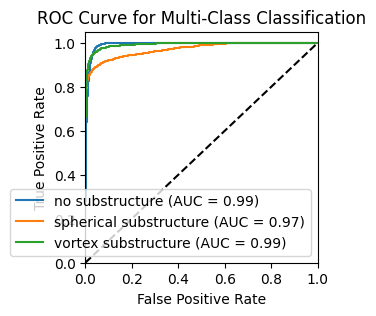

In [13]:
model.eval()  # Set model to evaluation mode

val_loss = 0.0
correct_predictions = 0
total_samples = 0

y_true = []
y_scores = []

with torch.no_grad():  # Disable gradient computation
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

        loss = criterion(outputs, labels)
        val_loss += loss.item() * labels.size(0)  # Accumulate loss

        y_true.extend(labels.cpu().numpy())
        y_scores.extend(outputs.cpu().numpy())

# Compute average loss and accuracy
val_loss /= total_samples
val_acc = correct_predictions / total_samples

print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# Convert lists to NumPy arrays for ROC-AUC calculation
y_true = np.array(y_true)
y_scores = np.array(y_scores)

    # ROC-AUC computation
n_classes = len(val_data.class_to_idx)  #  len(class_dict) # or len(np.unique(y_true))]
fpr, tpr, roc_auc = {}, {}, []

for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), y_scores[:, i])
        roc_auc.append(roc_auc_score((y_true == i).astype(int), y_scores[:, i]))

    # Average AUC score
roc_score = np.mean(roc_auc)
print(f"ROC AUC Score: {roc_score:.4f}")

    # Plot ROC curve
plt.figure(figsize=(3,3))
class_dict = {0: "no substructure", 1: "spherical substructure", 2: "vortex substructure"}

for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f"{class_dict[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.show()

## Preprocess the image

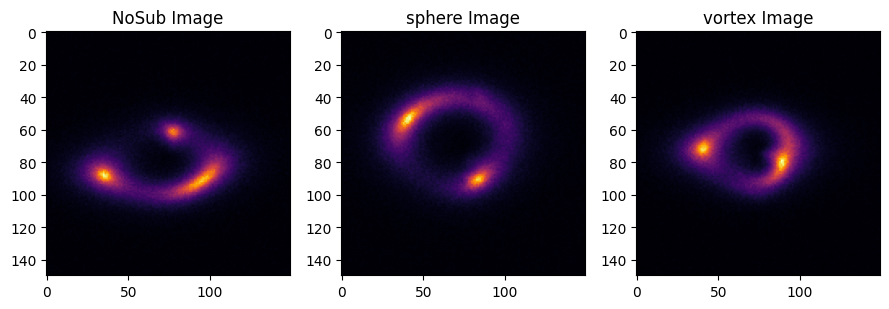

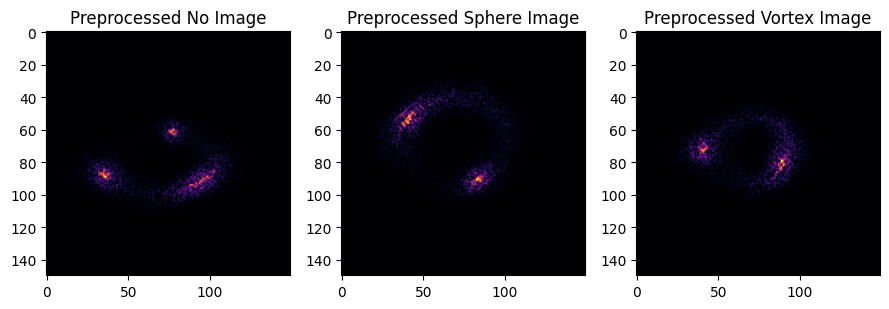

In [11]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def preprocess(image):
    image = torch.tensor(image, dtype=torch.float32)  # Ensure tensor conversion
    image = torch.nan_to_num(image, nan=1e-6)  
    imax = torch.max(image)
    
    if imax == 0:  # Prevent division by zero
        imax = 1e-6  

    log = torch.square(torch.sin(image / imax))
    log = torch.nan_to_num(log, nan=0.0)

    gradient_x = torch.gradient(log, dim=0)[0]  # Fixed dim to avoid index errors
    gradient_y = torch.gradient(log, dim=1)[0]

    gradient_x = torch.nan_to_num(gradient_x, nan=0.0)
    gradient_y = torch.nan_to_num(gradient_y, nan=0.0)

    gradient = torch.gradient(gradient_x, dim=0)[0] + torch.gradient(gradient_y, dim=1)[0]
    gradient = torch.nan_to_num(gradient, nan=0.0)

    tan = torch.tanh(gradient)
    absolute = torch.abs(tan)
    
    return absolute

# Load images
axion = np.load("./dataset/train/no/1011.npy", allow_pickle=True)[0]
cdm = np.load("./dataset/train/vort/10.npy", allow_pickle=True)[0]
nosub = np.load("./dataset/train/sphere/1.npy", allow_pickle=True)[0]

fig, axs = plt.subplots(1, 3, figsize=(9, 3))

# Display original images
axs[0].imshow(axion, cmap="inferno")
axs[0].set_title("NoSub Image")
axs[1].imshow(nosub, cmap="inferno")
axs[1].set_title("sphere Image")
axs[2].imshow(cdm, cmap="inferno")
axs[2].set_title("vortex Image")
plt.tight_layout()
plt.show()

# Preprocess and display processed images
fig, axs = plt.subplots(1, 3, figsize=(9, 3))

axs[0].imshow(preprocess(axion).detach().numpy(), cmap="inferno")
axs[0].set_title("Preprocessed No Image")
axs[1].imshow(preprocess(nosub).detach().numpy(), cmap="inferno")
axs[1].set_title("Preprocessed Sphere Image")
axs[2].imshow(preprocess(cdm).detach().numpy(), cmap="inferno")
axs[2].set_title("Preprocessed Vortex Image")

plt.tight_layout()
plt.show()
